In [1]:
import numpy as np 
import cv2
from cv2 import dnn
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
def coloriser(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    prototext = r"Model\colorization_deploy_v2.prototxt"
    model = r"Model\colorization_release_v2.caffemodel"
    points = r"Model\pts_in_hull.npy"

    net = dnn.readNetFromCaffe(prototext, model)
    pts = np.load(points)

    class8 = net.getLayerId('class8_ab')
    conv8 = net.getLayerId('conv8_313_rh')
    pts = pts.transpose().reshape(2, 313, 1, 1)

    net.getLayer(class8).blobs = [pts.astype('float32')]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype='float32')]

    scaled = img.astype('float32') / 255.0

    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (img.shape[1], img.shape[0]))

    L = cv2.split(lab)[0]
    colorised = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    colorised = cv2.cvtColor(colorised, cv2.COLOR_LAB2RGB)
    colorised = np.clip(colorised, 0, 1)

    colorised = (255 * colorised).astype('uint8')

    return colorised

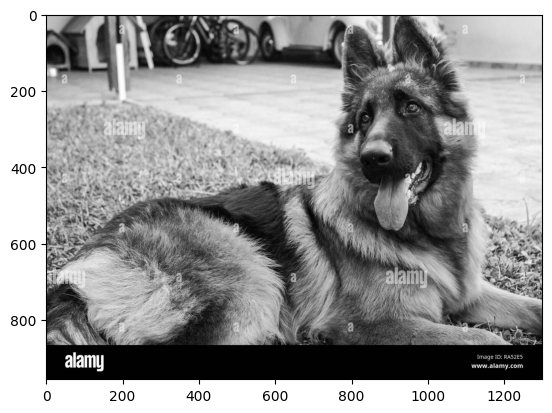

In [26]:
inp = Image.open('test_images\german shepherd.jpg')
plt.imshow(inp)

In [27]:
inp = np.array(inp)
op = coloriser(inp)
# op = cv2.cvtColor(op, cv2.COLOR_RGB2BGR)

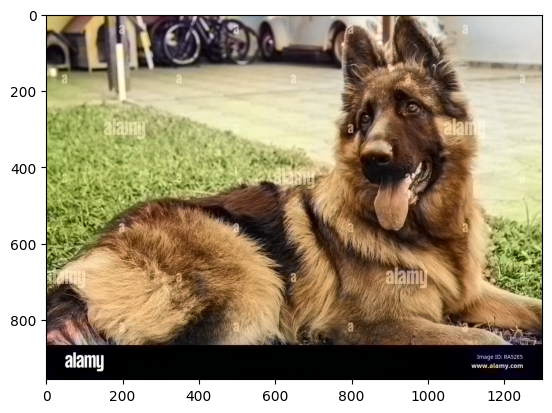

In [28]:
plt.imshow(op)

### Accuracy Check

We'll use an already colored image and convert it to Grayscale   
Then we'll apply our model on it to colorise it and compare the results

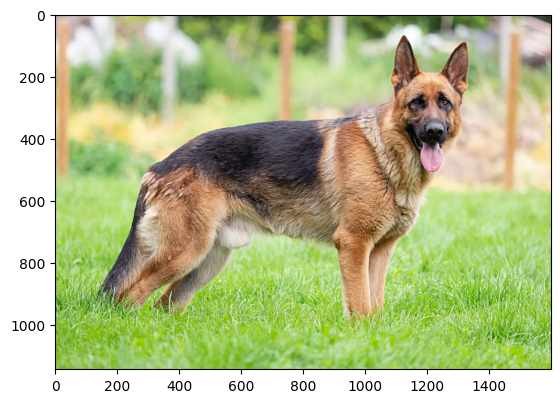

In [60]:
#Load Colored Image
colored_image = Image.open('test_images\German-Shepherd-colored.jpg')
plt.imshow(colored_image)

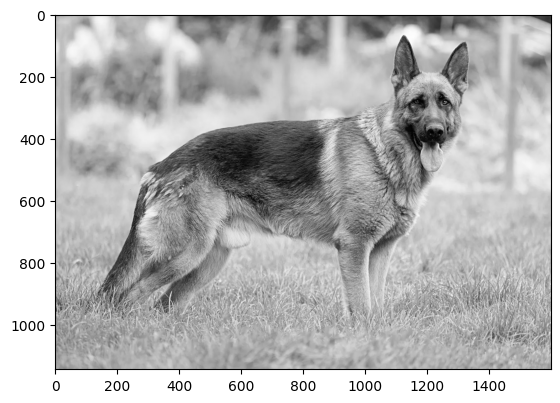

In [61]:
#Covert the Image to Grayscale
colored_image_bw = colored_image.convert('L').convert('RGB')
plt.imshow(colored_image_bw, cmap='gray')

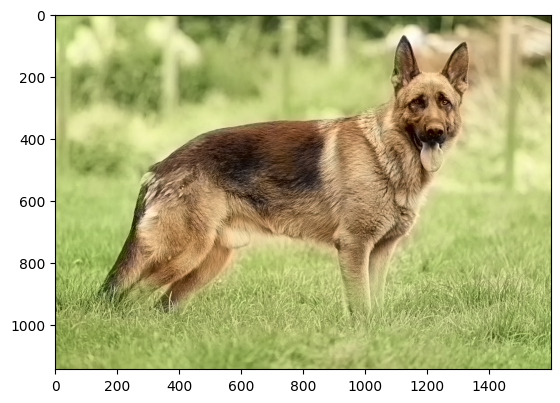

In [62]:
#Recolor the image using our model
recolor = coloriser(np.array(colored_image_bw))
plt.imshow(recolor)

### Comparison

Text(0.5, 1.0, 'Recolor')

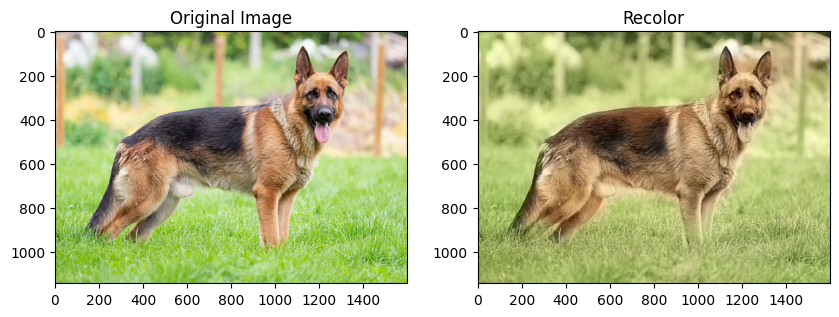

In [63]:
#Plotting the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(colored_image))
axes[0].set_title('Original Image')

axes[1].imshow(recolor)
axes[1].set_title('Recolor')

In [64]:
#Defining accuracy measure

def pixel_color_accuracy(image1, image2):
    abs_diff = np.abs(image1 - image2)
    total_pixel_offset = np.sum(abs_diff)
    total_pixels = np.prod(image1.shape)
    acc = total_pixel_offset / (total_pixels * 255) 
    acc *= 100
    return acc

In [65]:
pixel_color_accuracy(recolor, np.array(colored_image))

54.7099132587184